> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

<h4><div style="text-align: right"> Due date: April 1, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab04.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [77]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-03-29 11:26:03.937758


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [78]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [79]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [80]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [81]:
print('STEP 1: DEFINE DATASET')

train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        #############
                        #위의 조건대로 datset을 transform해주는데 결과와 동일하게 나오게 하기 위해서 순서를
                        #바꾸어 주었다. zero padding을 먼저 하고 randomaffine을 하여 숫자가 랜덤한 위치에
                        #위치하도록 하였다.
                        transform=transforms.Compose([
                            transforms.Pad(padding=26),
                            #translate을 0.25,0.25로 설정한 이유는 image size가 80x80인데 40x40의 숫자가 있는 region을 
                            #가로세로 20 이하로 랜덤하게 움직일 수 있다는 것이다.
                            transforms.RandomAffine(degrees=45, scale=(0.7,1.2), translate=(0.25, 0.25)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=0.1307,std=0.3081)
                        ]),
                        #############
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        #############
                        #test_dataset도 train_dataset과 똑같이 transform해준다.
                        transform=transforms.Compose([
                            transforms.Pad(padding=26),
                            transforms.RandomAffine(degrees=45, scale=(0.7,1.2), translate=(0.25, 0.25)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=0.1307,std=0.3081)
                        ]),
                        #############
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [82]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


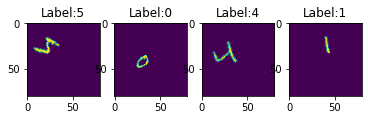

In [83]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [84]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [85]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):
    
#############
    def __init__(self):
        super(STN_CNN,self).__init__()
        #CNN Layer, 위에 주어진 조건대로 설계한다
        self.CNN_layer=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        
        #마지막에 숫자가 무엇인지 classification, 숫자가 10개이므로 out_features=10을 사용한다.
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*5*5, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=10)
        )
        #ST module에서 localization 부분의 2 convolutional layer부분이다. 
        self.localization = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0),#(1,80,80)->(20,76,76)
            nn.MaxPool2d(kernel_size=2, stride=2), #(20,76,76)->(20,38,38)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=0),#(20,38,38)->(20,34,34)
            nn.ReLU(inplace=True)
        )
        #localization 부분의 2 fully-connected layer 부분이다.
        self.fc_loc=nn.Sequential(
            nn.Linear(in_features=20*34*34, out_features=20),
            nn.ReLU(inplace=True),
            nn.Linear(20,6)
        )
        #마지막 regression layer를 identity transform으로 initialize해준다.
        self.fc_loc[-1].weight.data.zero_()
        self.fc_loc[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        #ST module 뒤에 downsampling을 위한 averagepooling
        self.AveragePool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def STN(self,x):
        xs=self.localization(x)
        xs=xs.view(xs.size(0),-1) #fc layer를 통과시키기 위해 차원 변환
        xs=self.fc_loc(xs)
        theta=xs.view(-1,2,3)#theta 값을 2 X 3으로 바꿔준다
        
        grid=F.affine_grid(theta, x.size())#sampling할 좌표를 뽑을 grid를 만드는 함수
        x=F.grid_sample(x,grid)#grid를 바탕으로 input에서 sampling하는 함수
        
        return x
    
    def forward(self,x):
        x=self.STN(x)
        x=self.AveragePool(x)
        
        x=self.CNN_layer(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        
        return x
#############


STEP 3: CREATE MODEL CLASS (STN_CNN)


In [86]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
CNN_layer.0.weight 	 torch.Size([32, 1, 9, 9])
CNN_layer.0.bias 	 torch.Size([32])
CNN_layer.3.weight 	 torch.Size([64, 32, 7, 7])
CNN_layer.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [87]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [89]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
criterion = nn.CrossEntropyLoss() #cross entropy loss
#############

# Model to GPU
model.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        img = img.to(device0)
        label = label.to(device0)
        
        # gradient 값 0으로 초기화
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(img)

        # Loss 계산: cross entropy loss
        loss = criterion(outputs, label)

        # back propagation을 통해 gradient 계산
        loss.backward()

        # parameters 업데이트
        optimizer.step()
        #############
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model.eval()
    #############
      # Accuracy 계산         
    correct = 0
    total = 0
    accuracy=0
    # test data에 model 적용 
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device0)
        labels = labels.to(device0)

        # Forward pass
        outputs = model(images)

        # maximum value에서 prediction을 가져온다.
        _, predicted = torch.max(outputs.data, 1)

        # 특정 label의 데이터 총 개수
        total += labels.size(0)
        
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()
        
    accuracy = 100 * correct.item() / total
    
    print('\nTest set accuracy:{}/{} ({:.2f}%)\n'.format(1*correct.item(),total,accuracy))
    #############
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :#best accuracy를 저장한다.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:0.119587  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.050109  

Test set accuracy:9642/9984 (96.57%)

////Epoch elapsed time: 9.486859798431396////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.074339  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.090970  

Test set accuracy:9648/9984 (96.63%)

////Epoch elapsed time: 9.7366201877594////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.186528  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.052917  

Test set accuracy:9686/9984 (97.02%)

////Epoch elapsed time: 9.479197025299072////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.036229  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.073424  

Test set accuracy:9716/9984 (97.32%)

////Epoch elapsed time: 9.495755434036255////

Train Epoch: 4 [0/60000 (0%) / Learning

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [90]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [91]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  99.15865384615384


In [92]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [93]:
#왜곡된 이미지와 STN을 통해 보정된 이미지의 비교를 위한 class이다.
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        #############
        return self.model.STN(x) #STN을 통과
        #############
    
    def visualize(self, img):
        #############
        trans_img=self.forward_stn(img)
        
        #4X4짜리 grid를 만들고 이미지를 reprocess한다.
        img_show=v_utils.make_grid(img,nrow=4)
        trans_img_show=v_utils.make_grid(trans_img,nrow=4)
        img_rep=reprocess_image(img_show)
        trans_img_rep=reprocess_image(trans_img_show)
        
        fig=plt.figure()
        #왜곡된 이미지
        fig.add_subplot(1,2,1).set_title('Dataset Images')
        plt.imshow(img_rep)
        #보정된 이미지
        fig.add_subplot(1,2,2).set_title('Transformed Images')
        plt.imshow(trans_img_rep)
        plt.show()
        #############
  

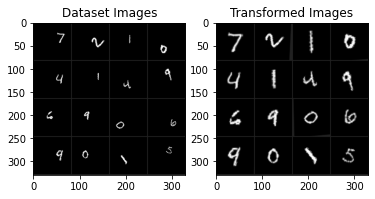

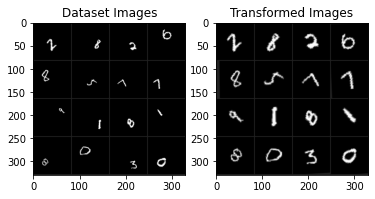

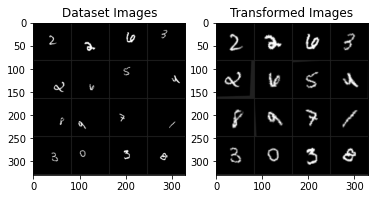

In [94]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [95]:
#############
#ST module을 뺀 기본적인 CNN이다.
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        self.CNN_layer=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*5*5, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=10)
        )
        
        self.AveragePool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self,x):
        x=self.AveragePool(x)#STN과 마찬가지로 average pooling으로 downsampling
        
        x=self.CNN_layer(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        
        return x
        
#############


In [96]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
CNN_layer.0.weight 	 torch.Size([32, 1, 9, 9])
CNN_layer.0.bias 	 torch.Size([32])
CNN_layer.3.weight 	 torch.Size([64, 32, 7, 7])
CNN_layer.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [97]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [98]:
#############
print('STEP 6: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()


# Model to GPU
model_nostn.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        
        img = img.to(device0)
        label = label.to(device0)
        
        # gradient 값 0으로 초기화
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_nostn(img)

        # Loss 계산: cross entropy loss
        loss = criterion(outputs, label)

        # back propagation을 통해 gradient 계산
        loss.backward()

        # parameters 업데이트
        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model_nostn.eval()
    
      # Accuracy 계산         
    correct = 0
    total = 0
    accuray=0
    # test data에 model 적용 
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device0)
        labels = labels.to(device0)

        # Forward pass
        outputs = model_nostn(images)

        # maximum value에서 prediction을 가져온다.
        _, predicted = torch.max(outputs.data, 1)

        # 특정 label의 데이터 총 개수
        total += labels.size(0)
        
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()
        
    accuracy = 100 * correct.item() / total
    
    print('\nTest set accuracy:{}/{} ({:.2f}%)\n'.format(1*correct.item(),total,accuracy))
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_nostn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)
#############

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.306770  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.245924  

Test set accuracy:6236/9984 (62.46%)

////Epoch elapsed time: 9.413684368133545////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:1.090206  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.825509  

Test set accuracy:7689/9984 (77.01%)

////Epoch elapsed time: 9.327645301818848////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.753809  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.516020  

Test set accuracy:8412/9984 (84.25%)

////Epoch elapsed time: 9.050367832183838////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.534647  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.432200  

Test set accuracy:8718/9984 (87.32%)

////Epoch elapsed time: 9.002285718917847////

Train Epoch: 4 [0/60000 (0%) / Learni

#### Best accuracy of the model without ST module


In [99]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  97.60616987179488


### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>

주어진 조건에서는 random location에 둔 후에 zero padding을 하라고 나와있지만, problem에서 주어진 결과를 보면, zero padding을 한 후에 random location을 해줘야 한다.

이번에 사용한 dataset은 RTS인데 결과를 살펴보면 translated와 scaled에 대해서는 잘 수행이 된 것을 볼 수 있으나, rotated는 잘 수행이 되지 않은 것을 볼 수 있다. translated를 수행하지 않고 추가적인 실험을 진행해보았을 때 scaled와 rotated 모두 잘 수행되었다. rotated만 수행해보면 잘 수행되었다. 이를 통해 유추해보았을 때, translated, scaled, rotated가 모두 되었을 때, rotated보다 translated의 영향이 훨씬 커서 이를 보정시키는 것만 집중했을 것이다.

ST module이 있는 네트워크와 없는 네트워크를 비교해 보았을 때, 있는 네트워크의 best accuracy는 99.15고 없는 네트워크의 best accuracy는 97.61이다. 큰 차이는 나지 않지만 명백하게 ST module이 있는 네트워크의 정확도가 높고 특히나 ST module이 있는 네트워크는 epoch 5 만에 97.61을 넘어선 것을 볼 수 있다. (ST module이 없는 네트워크는 epoch 58에서 accuracy가 97.61이다) 걸리는 시간은 ST module이 있는 네트워크가 약간 더 많이 걸리지만 차이가 거의 나지 않는다.